In [1]:
ENV["GKS_ENCODING"]="utf8"
using Plots
using Statistics
using JSON
using Dates
using HTTP

Some utility functions that I put together to make the notebook a bit less verbose

In [2]:
include("covidplotutils.jl");

Getting the timeseries for all countries from one big JSON file

In [3]:
data = JSON.parse(String(HTTP.request("GET", "https://pomber.github.io/covid19/timeseries.json").body));

Extracting the country data from the parsed JSON. You can replace "Egypt" below by any country of interest

In [4]:
country="United Kingdom"
deaths, confirmed, dates, recovered = extract_country_data(country,data);

# Case fatality 

Doing further filteration of the data by only considering that data after a specific `death_threshold`. 

In [5]:
death_threshold=100
st=findfirst(x->x>death_threshold,deaths)
range_of_interest=st:length(dates)
deaths, _, dates, _ =deaths[range_of_interest], 
                                     confirmed[range_of_interest], 
                                     dates[range_of_interest], 
                                     recovered[range_of_interest];

A first plot of the death toll on a linear and logarithmic scale

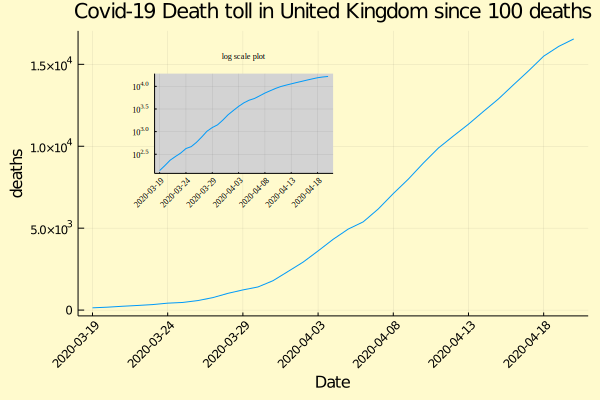

In [6]:
date_density=5
plot(1:length(dates),deaths, ylabel="deaths", label="",  xlabel="Date",
    title="Covid-19 Death toll in $country since $death_threshold deaths",
    xrotation=45, bg=:lemonchiffon,
    xticks=(1:date_density:length(dates),string.(dates[1:date_density:length(dates)])))
plot!(1:length(dates),deaths, label="",
    yscale=:log10,
    xrotation=45, titlefont = (5, "times"),tickfont = (5, "times"),
    xticks=(1:date_density:length(dates),string.(dates[1:date_density:length(dates)])), 
    inset=(1,bbox(0.15,0.15,0.35,0.35)), subplot=2, title="log scale plot", bg_inside=:lightgrey)

Doing a linear regression on the entire data using the log of deaths. We use that to calculate the daily rate. 

In [7]:
y=log.(deaths)
x=[ones(length(dates)) [1:length(dates)...]]
v=x\y
using Printf
@printf("Daily rate %2.2f",exp(v[2]))

Daily rate 1.17

We can see how good of fit we get on a log scale. 

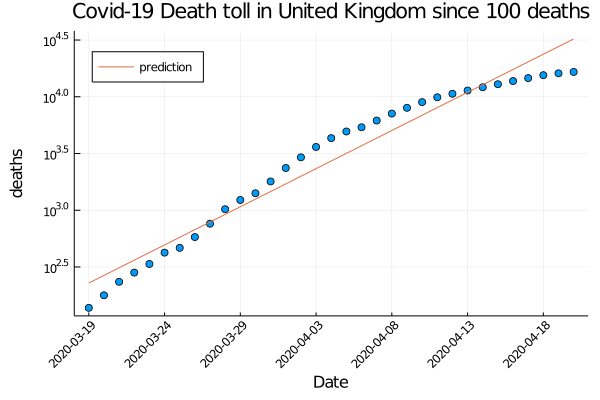

In [8]:
scatter(1:length(dates),deaths, ylabel="deaths", label="",  xlabel="Date",
    title="Covid-19 Death toll in $country since $death_threshold deaths", 
    yscale=:log10,
    legend=:topleft, xrotation=45, 
    xticks=(1:date_density:length(dates),string.(dates[1:date_density:length(dates)])))
plot!([exp(v[1]+v[2]*x) for x=1:length(dates)], label="prediction")

Switching back to a  linear scale, we observe how the linear least square fit changed in the last 10 days. 

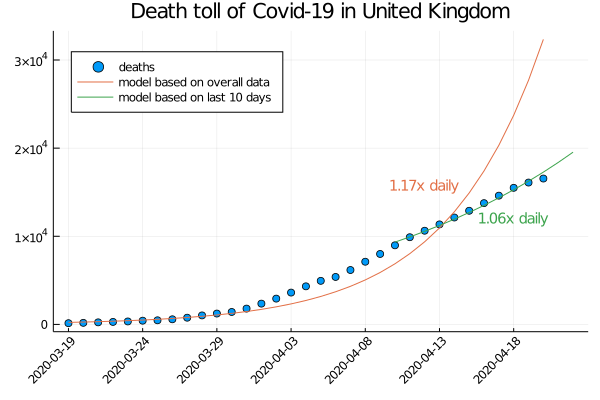

In [9]:
y=log.(deaths)
x=[ones(length(dates)) [1:length(dates)...]]
v=x\y
p=scatter(1:length(dates),deaths, 
    label="deaths", title="Death toll of Covid-19 in $country", 
    legend=:topleft, xrotation=45, 
    xticks=(1:date_density:length(dates),string.(dates[1:date_density:length(dates)])))
plot!(p,[exp(v[1]+v[2]*x) for x=1:length(dates)], label="model based on overall data")
y_range=[extrema(p.series_list[2][:y])...] |> diff |> x->ceil(Int,x[1])
x_loc=length(dates)-8
y_loc=exp(v[1]+v[2]*x_loc)
y_loc+=y_range*.2
plot!(p,ann=[(x_loc,y_loc,Plots.text(@sprintf("%2.2fx daily",exp(v[2])),10, :center,
             p.series_list[2].plotattributes[:linecolor]))], ylim=450)
days_in_past=10
start_point=length(deaths)-days_in_past
y=log.(deaths[start_point:end])
x=[ones(length(start_point:length(dates))) [start_point:length(dates)...]]
v=x\y
model_range=length(dates)-days_in_past:length(dates)+2
plot!(p,model_range,[exp(v[1]+v[2]*x) for x=model_range], label="model based on last $days_in_past days")
x_loc=length(dates)-2
y_loc=exp(v[1]+v[2]*x_loc)
y_loc-=y_range*.10
plot!(p,ann=[(x_loc,y_loc,Plots.text(@sprintf("%2.2fx daily",exp(v[2])),10, :center,
             p.series_list[3].plotattributes[:linecolor]))], ylim=450)

Using the most reccent model, based on the last 10 day, we can now try to calculate how many days will take to reach a particular number of `target_deaths`. 

In [10]:
target_deaths=100_000
@printf(
"It will take %d days to reach %d deaths from today.
We have have doubling period of %d days. 
This is based on a exponential growth model of data based on the  last %d days.",
    days_till_target_number(100_000)[2], target_deaths, days_till_target_number(100_000)[1],days_in_past )

It will take 30 days to reach 100000 deaths from today.
We have have doubling period of 11 days. 
This is based on a exponential growth model of data based on the  last 10 days.

We can now construct a series of models, based on five day intervals and see how well they fit for the following five days

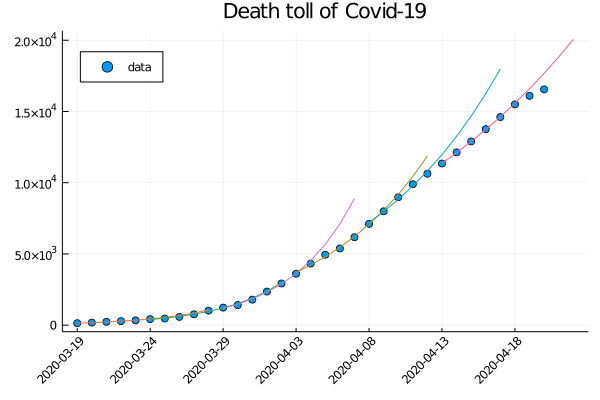

In [11]:
segments, v_interval=segmented_models(deaths)
p=plot_whisker_fit(deaths, v_interval,segments,dates, "Death toll")

We can now look at how the doubling times change over times, using the above series of models 

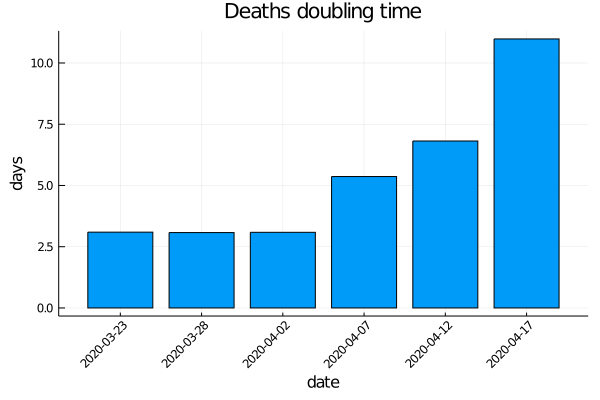

In [12]:
plot_doubling_times(deaths,v_interval,segments,dates,"Deaths")

This can be compared with the figures in the "[our world in data site](https://ourworldindata.org/coronavirus#global-comparison-where-are-confirmed-deaths-increasing-most-rapidly)" 

# Confirmed infected cases

We look at at the situation after `confirmed_threshold` confirmed cases, we start by doing data filtration 

In [13]:
confirmed_threshold=1000
deaths, confirmed, dates, recovered = extract_country_data(country,data);
st=findfirst(x->x>confirmed_threshold, confirmed)
range_of_interest=st:length(dates)
confirmed, dates=confirmed[range_of_interest], dates[range_of_interest];

Doing a log plot on the data 

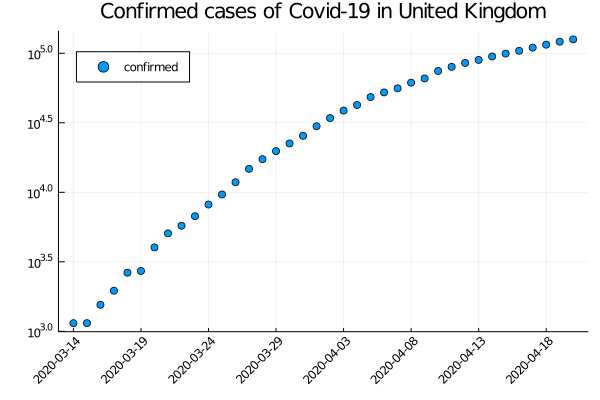

In [14]:
scatter(1:length(dates),confirmed, 
    yscale=:log10,
    label="confirmed", title="Confirmed cases of Covid-19 in $country", 
    legend=:topleft, xrotation=45, 
    xticks=(1:date_density:length(dates),string.(dates[1:date_density:length(dates)])))

This appears to follow a straight line. 

We now construct model varients based on the overall data, the last 10 days, and the last five days and try to visualize them. 

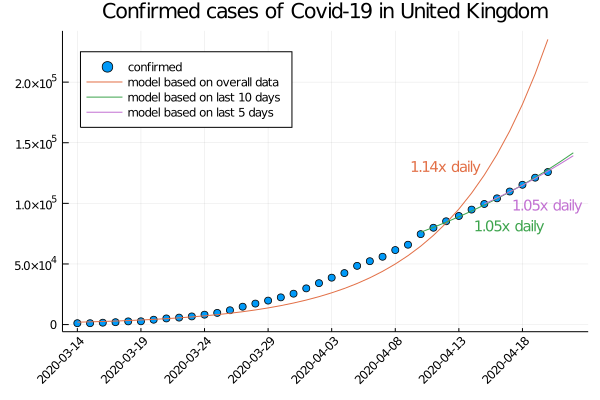

In [15]:
y=log.(confirmed)
x=[ones(length(dates)) [1:length(dates)...]]
v=x\y
p=scatter(1:length(dates),confirmed, 
    label="confirmed", title="Confirmed cases of Covid-19 in $country", 
    legend=:topleft, xrotation=45, 
    xticks=(1:date_density:length(dates),string.(dates[1:date_density:length(dates)])))
plot!(p, [exp(v[1]+v[2]*x) for x=1:length(dates)], label="model based on overall data")
y_range=[extrema(p.series_list[2][:y])...] |> diff |> x->ceil(Int,x[1])
x_loc=length(dates)-8
y_loc=exp(v[1]+v[2]*x_loc)
y_loc+=y_range*.2
plot!(p,ann=[(x_loc,y_loc,Plots.text(@sprintf("%2.2fx daily",exp(v[2])),10, :center,
             p.series_list[2].plotattributes[:linecolor]))], ylim=450)
days_in_past=10
start_point=length(confirmed)-days_in_past
y=log.(confirmed[start_point:end])
x=[ones(length(start_point:length(dates))) [start_point:length(dates)...]]
v=x\y
model_range=length(dates)-days_in_past:length(dates)+2
plot!(p,model_range,[exp(v[1]+v[2]*x) for x=model_range], label="model based on last $days_in_past days")
x_loc=length(dates)-3
y_loc=exp(v[1]+v[2]*x_loc)
y_loc-=y_range*.12
plot!(p,ann=[(x_loc,y_loc,Plots.text(@sprintf("%2.2fx daily",exp(v[2])),10, :center,
             p.series_list[3].plotattributes[:linecolor]))], ylim=450)
days_in_past=5
start_point=length(confirmed)-days_in_past
y=log.(confirmed[start_point:end])
x=[ones(length(start_point:length(dates))) [start_point:length(dates)...]]
v=x\y
model_range=length(dates)-days_in_past:length(dates)+2
plot!(p,model_range,[exp(v[1]+v[2]*x) for x=model_range], label="model based on last $days_in_past days")
x_loc=length(dates)
y_loc=exp(v[1]+v[2]*x_loc)
y_loc-=y_range*.12
plot!(p,ann=[(x_loc,y_loc,Plots.text(@sprintf("%2.2fx daily",exp(v[2])),10, :center,
             p.series_list[4].plotattributes[:linecolor]))], ylim=450)

We notice here that recently the rate of the number of confirmed cases have been declining. 
We can look at the doubling times over 5 day intervals. We construct here series of models 

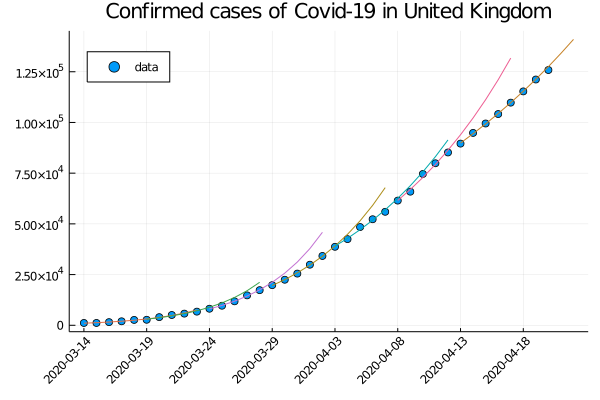

In [16]:
segments, v_interval=segmented_models(confirmed);
p=plot_whisker_fit(confirmed, v_interval,segments,dates)
plot!(p, title="Confirmed cases of Covid-19 in $country")

Using the most reccent model, based on the last 5 day, we can now try to calculate how many days will take to reach a particular number of `target_confirmed`. 

In [17]:
target_confirmed=1_000_000
tt=days_till_target_number(target_confirmed,confirmed,v_interval[end])
@printf(
"It will take %d days to reach %d confrimed cases from today.
We have have doubling period of %d days. 
This is based on a exponential growth model of data based on the  last %d days.",
    tt[2], target_confirmed, tt[1],5)

It will take 42 days to reach 1000000 confrimed cases from today.
We have have doubling period of 14 days. 
This is based on a exponential growth model of data based on the  last 5 days.

Lastly we look at the trend for the doubling times.

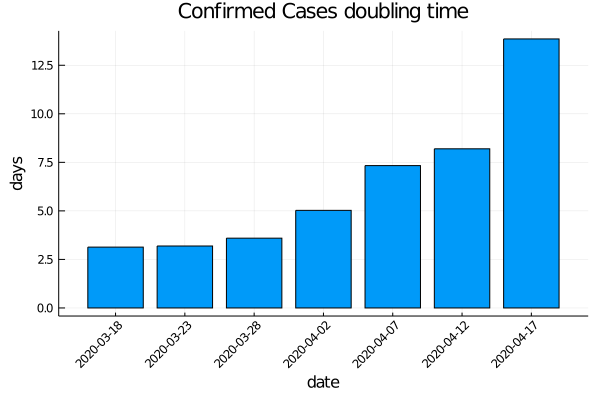

In [18]:
plot_doubling_times(confirmed,v_interval,segments,dates,"Confirmed Cases")